In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#sklearn - Machine Learning Package
import sklearn.model_selection as modsel
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

#statsmodels - traditional statistical modeling package
import statsmodels.api as sm

import cPickle as pickle

/Users/mlara/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load and Inspect Models

In [2]:
treeboost_file = 'best_treeboost_model_2.pkl'
logit_file = 'UCI_logit_model_rebuild.pkl'

In [3]:
model_treeboost = pickle.load(open(treeboost_file, "rb"))
model_treeboost

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0,
              n_estimators=150, presort='auto', random_state=123456,
              subsample=0.8, verbose=1, warm_start=False)

In [27]:
model_logit = pickle.load(open(logit_file, "rb"))
print(model_logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_match   No. Observations:               459930
Model:                            GLM   Df Residuals:                   459921
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -49.412
Date:                Thu, 22 Jun 2017   Deviance:                       98.825
Time:                        10:08:06   Pearson chi2:                 1.14e+06
No. Iterations:                    16                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cmp_fname_c1     6.2225      0.840      7.409      0.000       4.576       7.869
cmp_fname_c2     0.1051      1.732      0.061 

### Load Test Data Files

In [28]:
filenames = ['block_2.csv','block_3.csv','block_4.csv',
            'block_5.csv','block_6.csv','block_7.csv','block_8.csv',
            'block_9.csv','block_10.csv']

DT_list = []

for i in filenames:
    DT_list.append(pd.read_csv(i,na_values='?'))

for i in np.arange(len(DT_list)):
    DT_list[i]=DT_list[i].fillna(value = -1)

### Create Test Sets

In [29]:
str_preds = DT_list[0].columns[2:-1]
str_output = 'is_match'

X_test_list = []
y_test_list = []

for i in DT_list:
    X_test_list.append(i[str_preds])
    y_test_list.append(i[str_output])

## Out of Sample Model Performance - ROC Curves 

### Logit Model

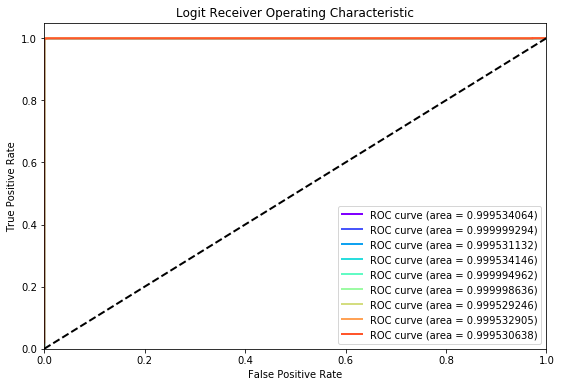

Mean Logit AUC: 0.999687224713


In [30]:
fpr=[]
tpr=[]
auc=[]
thresh=[]

predictors = ['cmp_fname_c1','cmp_fname_c2', 'cmp_lname_c1', 'cmp_lname_c2',
              'cmp_bd', 'cmp_bm', 'cmp_by', 'cmp_plz']
fpr_temp=[]
tpr_temp=[]
thresh_temp=[]
auc_temp=[]
for i in np.arange(len(X_test_list)):
    #Calculate Probabilities for Class 1
    test_probs = model_logit.predict(sm.add_constant(X_test_list[i][predictors],prepend=False))

    #Calculate FPR and TPR for Difference Thresholds
    fpr_temp, tpr_temp,thresh_temp = metrics.roc_curve(y_true=y_test_list[i],y_score = test_probs)

    #Calculate AUC for ROC
    auc_temp = metrics.roc_auc_score(y_true=y_test_list[i],y_score = test_probs)

    fpr.append(fpr_temp)
    tpr.append(tpr_temp)
    thresh.append(thresh_temp)
    auc.append(auc_temp)


plt.figure(figsize=(9,6))

colors = iter(cm.rainbow(np.linspace(0, 1, 10)))
for i in np.arange(len(fpr)):
    plt.plot(fpr[i], tpr[i], lw=2,color=next(colors), label='ROC curve (area = %0.9f)' % auc[i])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logit Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print('Mean Logit AUC: %s' % np.mean(auc))

### Tree Boosting Model

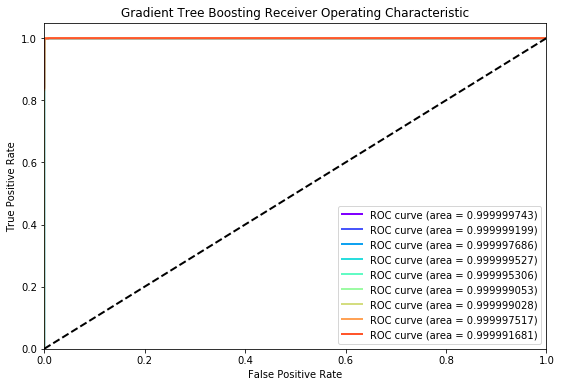

Mean Logit AUC: 0.999997637839


In [31]:
fpr=[]
tpr=[]
auc=[]
thresh=[]

fpr_temp=[]
tpr_temp=[]
thresh_temp=[]
auc_temp=[]
for i in np.arange(len(X_test_list)):
    #Calculate Probabilities for Class 1
    test_probs = model_treeboost.predict_proba(X_test_list[i])[:,1]

    #Calculate FPR and TPR for Difference Thresholds
    fpr_temp, tpr_temp,thresh_temp = metrics.roc_curve(y_true=y_test_list[i],y_score = test_probs)

    #Calculate AUC for ROC
    auc_temp = metrics.roc_auc_score(y_true=y_test_list[i],y_score = test_probs)

    fpr.append(fpr_temp)
    tpr.append(tpr_temp)
    thresh.append(thresh_temp)
    auc.append(auc_temp)


plt.figure(figsize=(9,6))

colors = iter(cm.rainbow(np.linspace(0, 1, 10)))
for i in np.arange(len(fpr)):
    plt.plot(fpr[i], tpr[i], lw=2,color=next(colors), label='ROC curve (area = %0.9f)' % auc[i])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Tree Boosting Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print('Mean Logit AUC: %s' % np.mean(auc))